# Load libraries

In [1]:
import os, torch, tqdm, logging
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

from unet.PyTorch import UNet, BESNet
from utils.dataset import PetDataset
from options.train_options import get_opt

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Configuration setting

In [2]:
return_edge = True
image_height = 128
image_width = 128
train_rate = 1
batch_size = 8
num_epoch = 30
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alpha = 0.5 # same setting from paper
beta = 1 # same setting from paper

# Torch dataset and dataloaders

In [3]:
base_dir = 'data/oxford-iiit-pet'
# bring train/test image file names - it is selected by the oxford-iiit-pet
train_filenames = [line.split()[0] for line in open(os.path.join(base_dir, 'annotations', 'trainval.txt'), 'r').readlines()]
test_filenames = [line.split()[0] for line in open(os.path.join(base_dir, 'annotations', 'test.txt'), 'r').readlines()]
# exclude files with invalid format - there are invalid data (2d image)
list_invalid_files = set(['Abyssinian_34', 'Egyptian_Mau_167', 'Egyptian_Mau_191', 'Egyptian_Mau_177', 'Egyptian_Mau_139', 'Egyptian_Mau_145', 'staffordshire_bull_terrier_22', 'Egyptian_Mau_129', 'staffordshire_bull_terrier_2', 'Egyptian_Mau_14', 'Abyssinian_5', 'Egyptian_Mau_186'])
train_filenames = [f for f in train_filenames if f not in list_invalid_files]
test_filenames = [f for f in test_filenames if f not in list_invalid_files]

trans_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_height, image_width)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # imagenet
])
trans_mask = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_height, image_width)),
    transforms.Normalize(0, 1 / 255.)
])

dataset = PetDataset(base_dir, train_filenames, transform_image = trans_image, transform_mask = trans_mask, return_edge = return_edge)
dataset_test = PetDataset(base_dir, test_filenames, transform_image = trans_image, transform_mask = trans_mask, return_edge = return_edge)
# train/val/test split
train_size = int(len(dataset) * train_rate)
val_size = len(dataset) - train_size
dataset_train, dataset_val = random_split(dataset, [train_size, val_size])
# make dataloader
dataloaders = {
    'train': DataLoader(dataset_train, batch_size = batch_size, shuffle = True, num_workers = 8),
    'val': DataLoader(dataset_val, batch_size = batch_size, shuffle = False, num_workers = 8),
    'test': DataLoader(dataset_test, batch_size = batch_size, shuffle = False, num_workers = 8)
}

# Load some example images to see the result

In [4]:
image_dir = os.path.join(base_dir, 'images')
edge_dir = os.path.join(base_dir, 'edges')
mask_dir = os.path.join(base_dir, 'masks')

In [5]:
sample_image_files = ['shiba_inu_100', 'Siamese_70', 'beagle_21', 'american_pit_bull_terrier_58', 'leonberger_84', 'pomeranian_88', 'staffordshire_bull_terrier_77', 'japanese_chin_49', 'Maine_Coon_153', 'samoyed_73']
list_images = [Image.open(os.path.join(image_dir, f + '.jpg')) for f in sample_image_files]
list_images = [torch.unsqueeze(trans_image(image), dim = 0).to(device) for image in list_images]
list_images_reshaped = [Image.open(os.path.join(image_dir, f + '.jpg')).resize((image_height, image_width)) for f in sample_image_files]

In [6]:
def show_result_unet(net, img_torch, img_raw, fname, return_output = True, show_result = False):
    mask = net(img_torch)
    mask = mask[0,0].detach().cpu().numpy()
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    axes[0].imshow(img_raw); axes[0].set_axis_off()
    axes[1].imshow(mask); axes[1].set_axis_off()
    fig.suptitle(fname, fontsize = 30)
    fig.tight_layout()
    if show_result:
        plt.show()
    else:
        plt.close()
    if return_output:
        fig.canvas.draw()
        return Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

def show_result_besnet(net, img_torch, img_raw, fname, return_output = True, show_result = False):
    edge, mask = net(img_torch)
    edge = edge[0,0].detach().cpu().numpy()
    mask = mask[0,0].detach().cpu().numpy()
    fig, axes = plt.subplots(1, 3, figsize = (15, 5))
    axes[0].imshow(img_raw); axes[0].set_axis_off()
    axes[1].imshow(edge); axes[1].set_axis_off()
    axes[2].imshow(mask); axes[2].set_axis_off()
    fig.suptitle(fname, fontsize = 30)
    fig.tight_layout()
    if show_result:
        plt.show()
    else:
        plt.close()
    if return_output:
        fig.canvas.draw()
        return Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# Train UNet

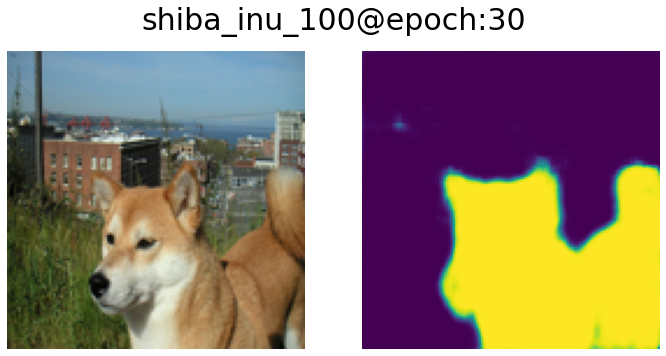

Epoch 29/30: 100%|██████████| 460/460 [00:53<00:00,  8.62it/s, error=0.06]


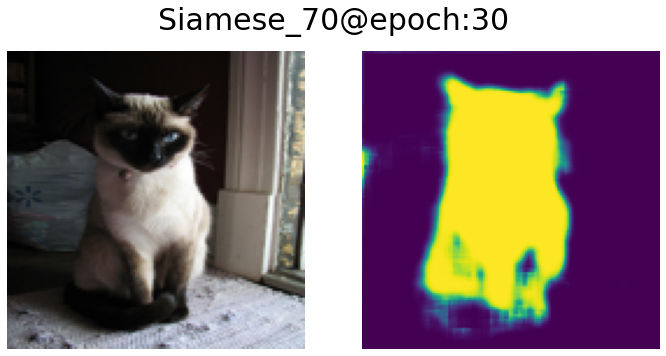

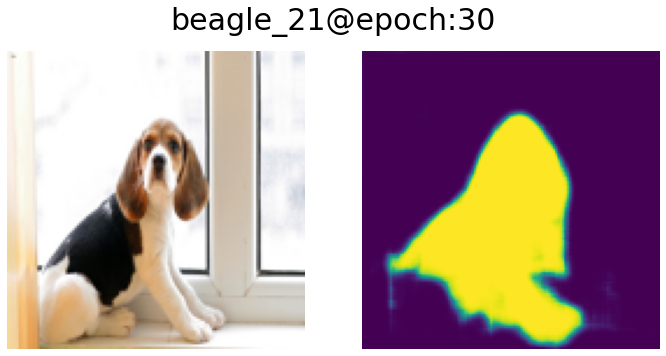

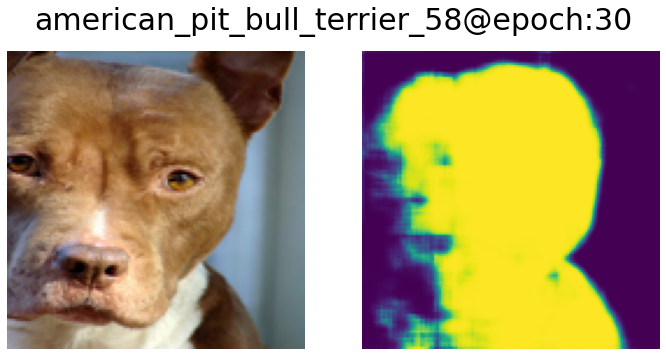

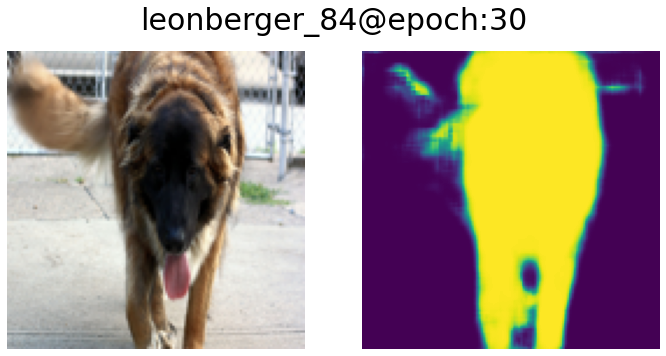

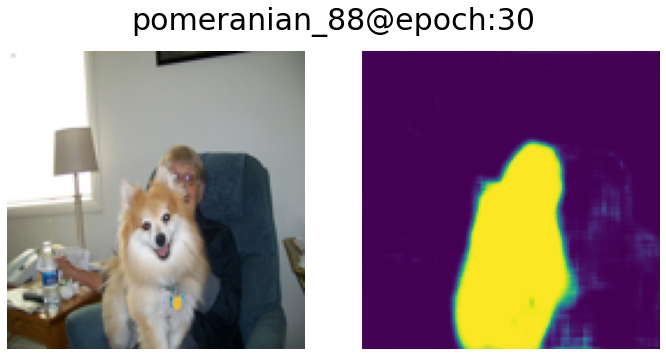

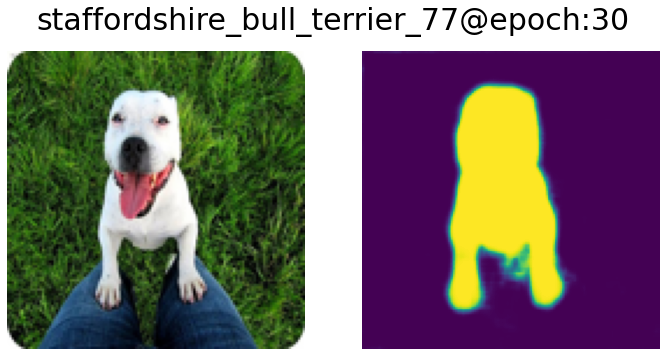

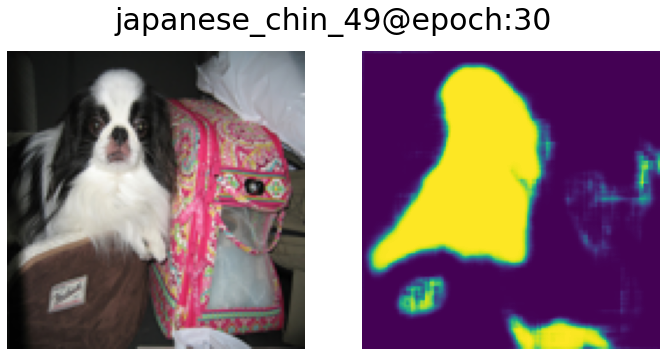

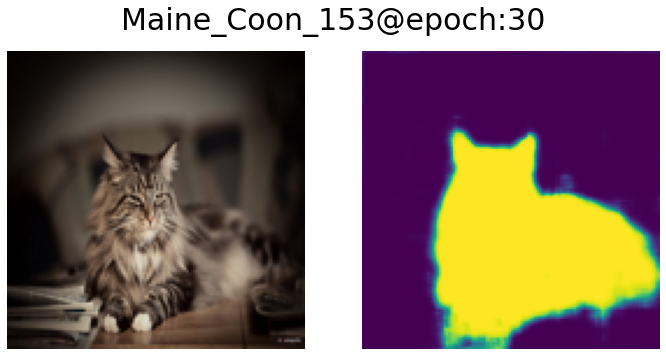

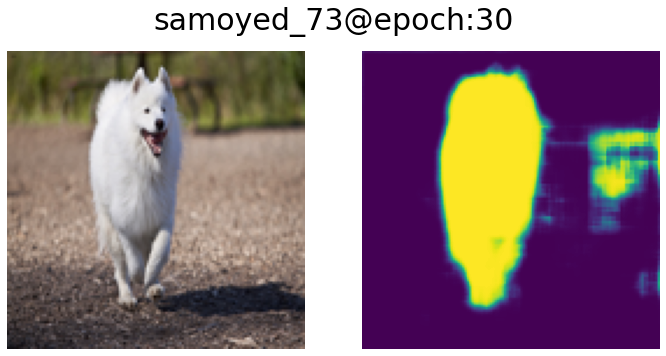

In [7]:
unet = UNet(3).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr = lr)
criterion = F.binary_cross_entropy
list_sample_result = []

for epoch in range(num_epoch):
    unet.train()
    pbar = tqdm.tqdm(total = len(dataloaders['train']), position = 0, desc = f'Epoch {epoch+1}/{num_epoch}')
    
    # show results for example files
    list_plots = []
    show_shiba = True
    for img_torch, img_raw, fname in zip(list_images, list_images_reshaped, sample_image_files):
        list_plots.append(show_result_unet(unet, img_torch, img_raw, f'{fname}@epoch:{epoch}', show_result = show_shiba))
        show_shiba = False
    list_sample_result.append(list_plots)
    
    for image, mask, _ in dataloaders['train']:
        # Load data
        image = image.to(device)
        mask = mask.to(device)
        # Forward
        pred = unet(image)
        # Get Loss
        loss = criterion(pred, mask)
        # weight updates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'error': np.round(loss.item(), 2)})
        pbar.update(1)
    clear_output(wait = True)
    
# show results for example files
list_plots = []
for img_torch, img_raw, fname in zip(list_images, list_images_reshaped, sample_image_files):
    list_plots.append(show_result_unet(unet, img_torch, img_raw, f'{fname}@epoch:{epoch+1}', show_result = True))
list_sample_result.append(list_plots)

for idx, fname in enumerate(sample_image_files):
    list_sample_result[0][idx].save(fp = f'./images/pet@unet-{fname}.gif', format = 'GIF', append_images = [list_sample_result[i+1][idx] for i in range(num_epoch)], save_all = True, duration = 200, loop = 0)

Progression result (gif file)

<img src="./images/pet@unet-shiba_inu_100.gif" width="750" align="center">

# Train BESNet without BECE Loss

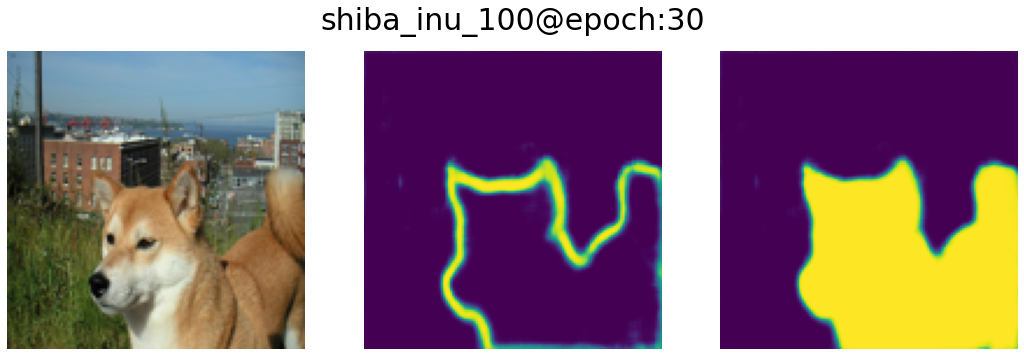

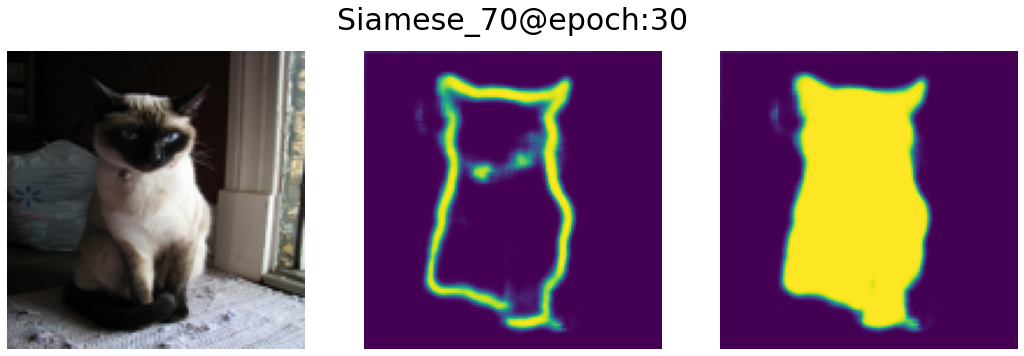

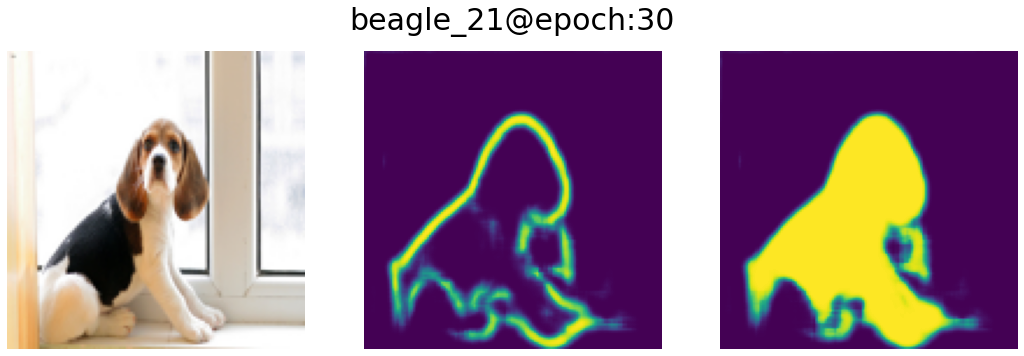

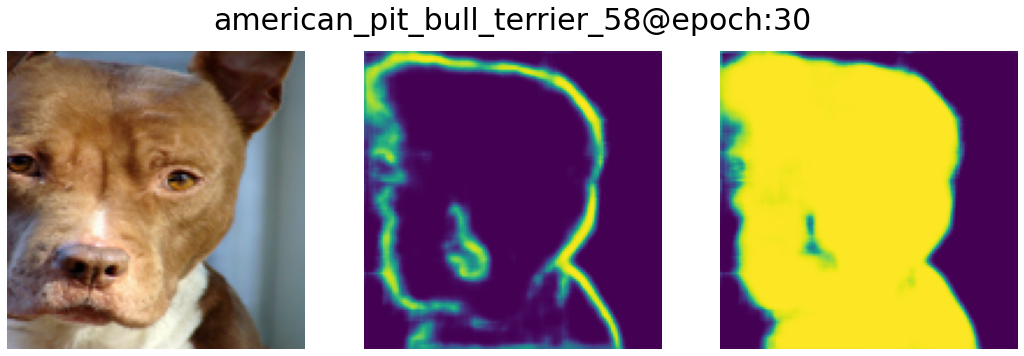

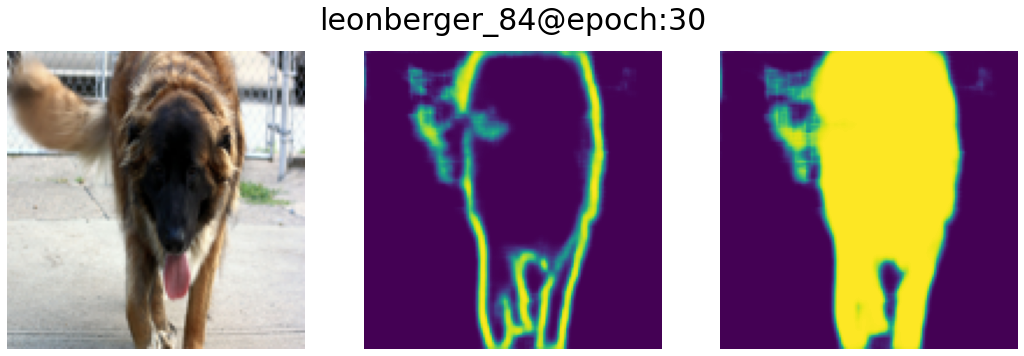

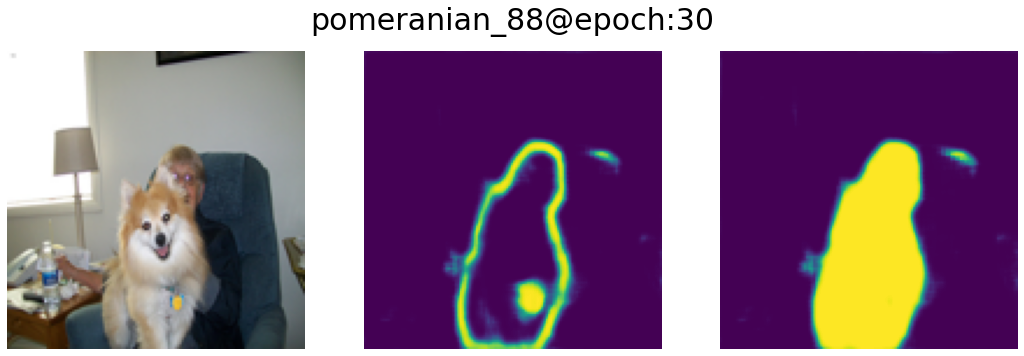

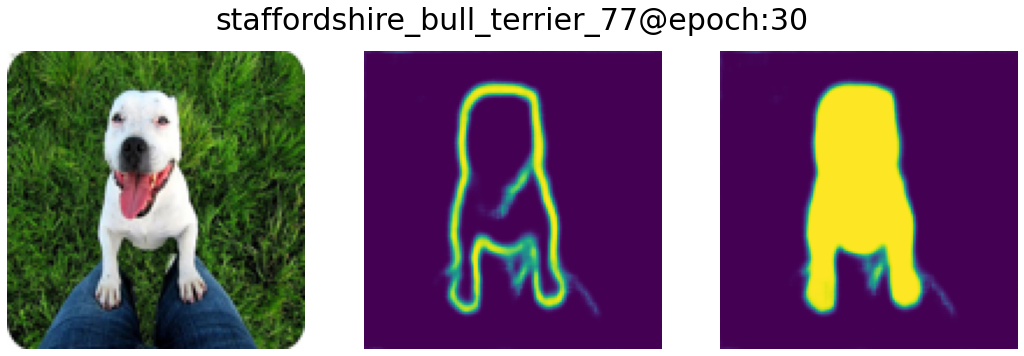

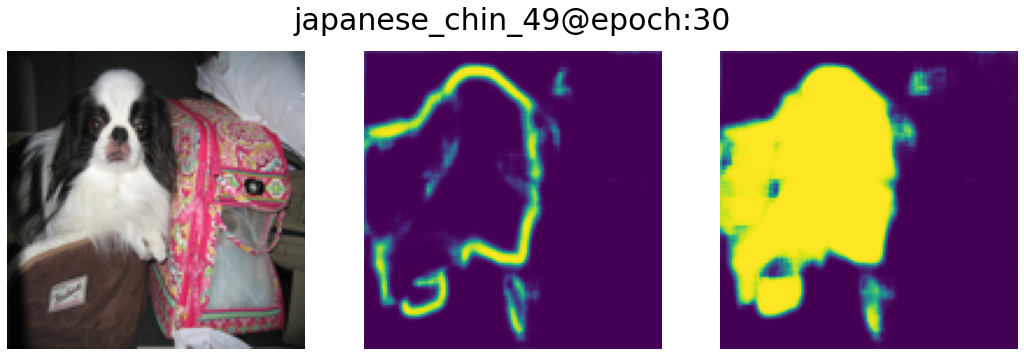

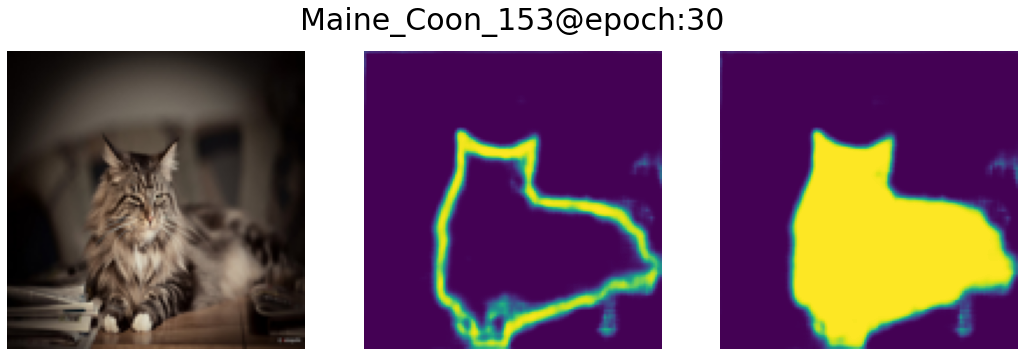

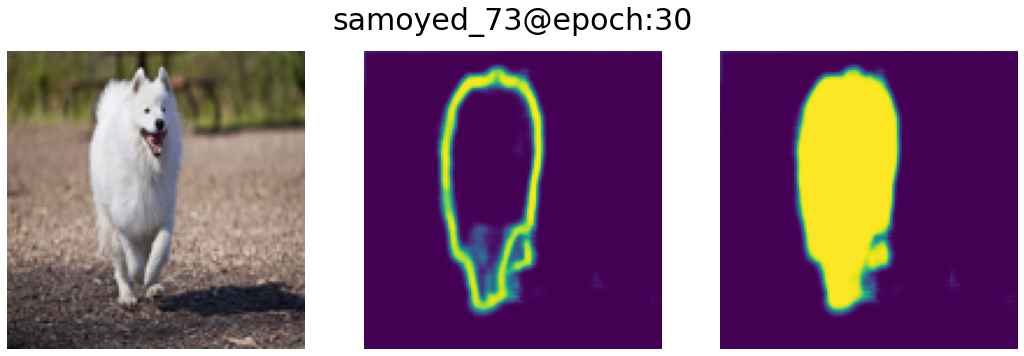

In [8]:
besnet = BESNet(3).to(device)
optimizer = torch.optim.Adam(besnet.parameters(), lr = lr)
criterion_bdp = F.binary_cross_entropy
criterion_mdp = F.binary_cross_entropy
list_sample_result = []

for epoch in range(num_epoch):
    besnet.train()
    pbar = tqdm.tqdm(total = len(dataloaders['train']), position = 0, desc = f'Epoch {epoch+1}/{num_epoch}')
    
    # show results for example files
    list_plots = []
    show_shiba = True
    for img_torch, img_raw, fname in zip(list_images, list_images_reshaped, sample_image_files):
        list_plots.append(show_result_besnet(besnet, img_torch, img_raw, f'{fname}@epoch:{epoch}', show_result = show_shiba))
        show_shiba = False
    list_sample_result.append(list_plots)
    
    for image, mask, edge in dataloaders['train']:
        # Load data
        image = image.to(device)
        mask = mask.to(device)
        edge = edge.to(device)
        # Forward
        bdp, mdp = besnet(image)
        # Get Loss
        bdp_loss = criterion_bdp(bdp, edge)
        mdp_loss = criterion_mdp(mdp, mask)
        loss = bdp_loss + mdp_loss
        # weight updates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'bdp_error': np.round(bdp_loss.item(), 2), 'mdp_error': np.round(mdp_loss.item(), 2), 'total_error': np.round(loss.item(), 2)})
        pbar.update(1)
    clear_output(wait = True)
    
# show results for example files
list_plots = []
for img_torch, img_raw, fname in zip(list_images, list_images_reshaped, sample_image_files):
    list_plots.append(show_result_besnet(besnet, img_torch, img_raw, f'{fname}@epoch:{epoch+1}', show_result = True))
list_sample_result.append(list_plots)

for idx, fname in enumerate(sample_image_files):
    list_sample_result[0][idx].save(fp = f'./images/pet@besnet_without_bece-{fname}.gif', format = 'GIF', append_images = [list_sample_result[i+1][idx] for i in range(num_epoch)], save_all = True, duration = 200, loop = 0)

Progression result (gif file)

<img src="./images/pet@besnet_without_bece-shiba_inu_100.gif" width="750" align="center">

# Train BESNet with BECE Loss

In [9]:
def mdp_bece_loss(output, target, bdp):
    bx = alpha * torch.max(beta - bdp, torch.zeros_like(bdp))
    loss = target * torch.log(output + torch.finfo(torch.float32).eps)
    loss += (1 - target) * torch.log(1 - output + torch.finfo(torch.float32).eps)
    return -loss.mean()

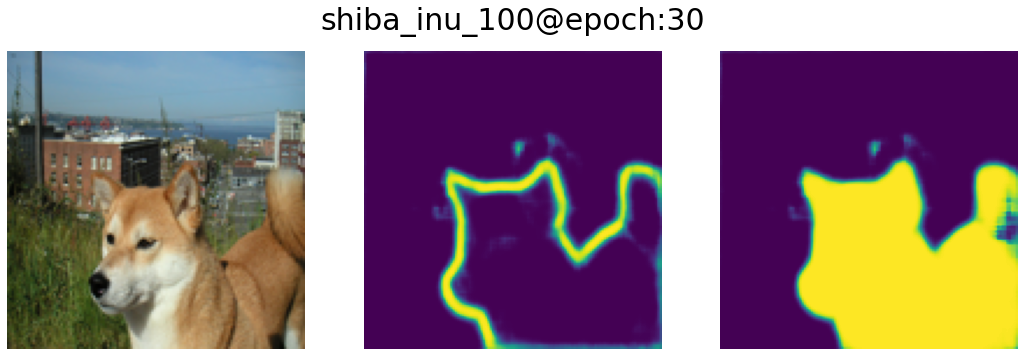

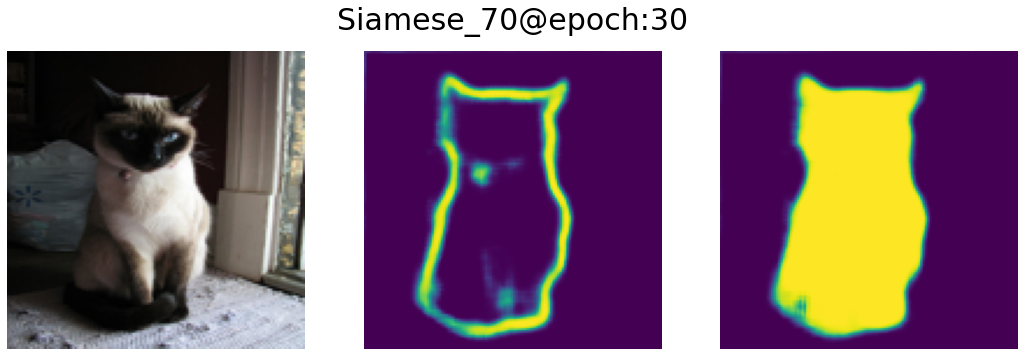

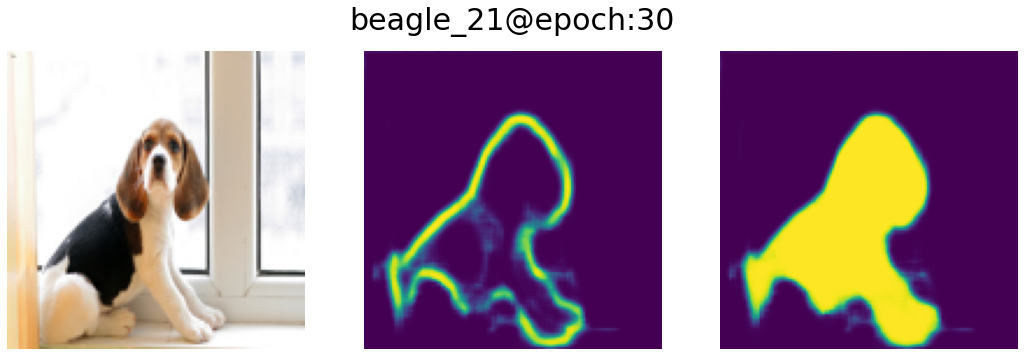

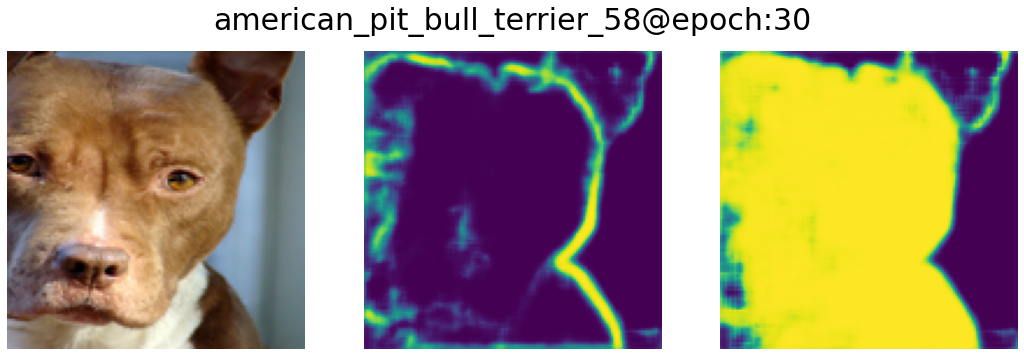

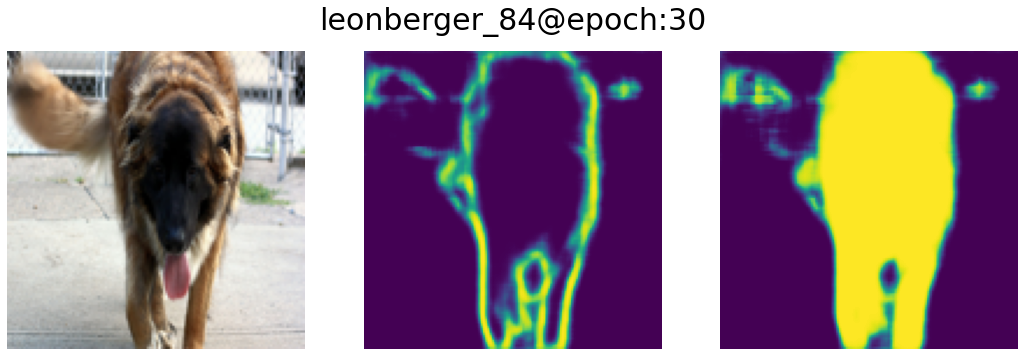

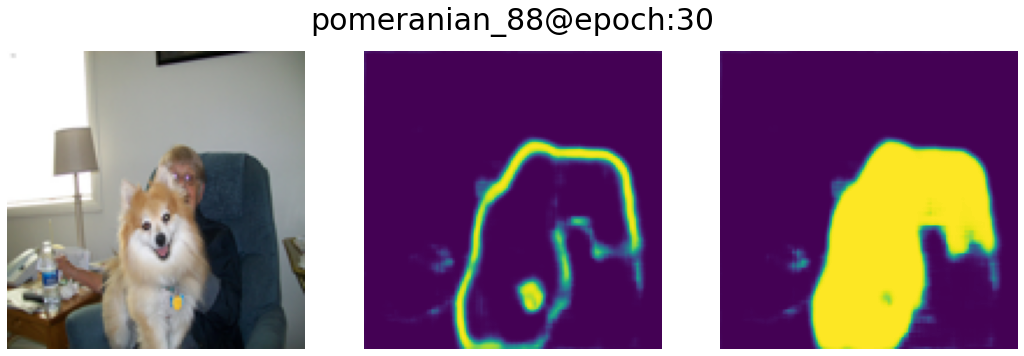

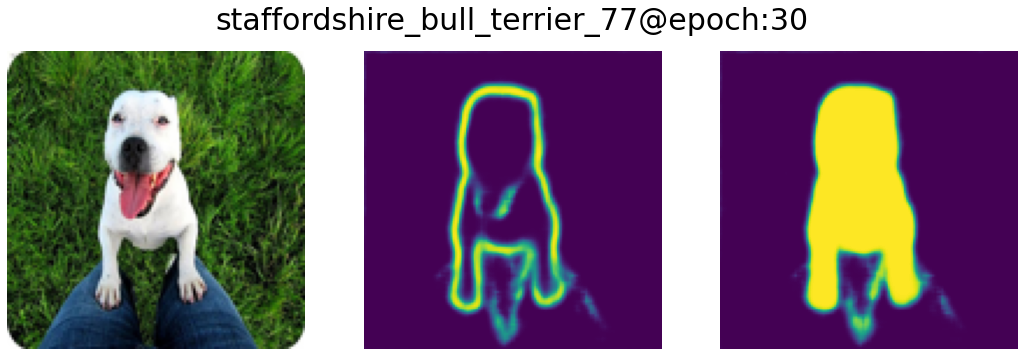

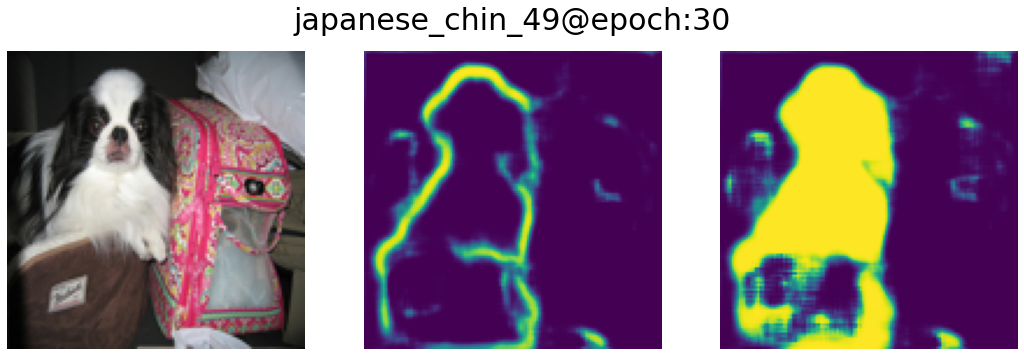

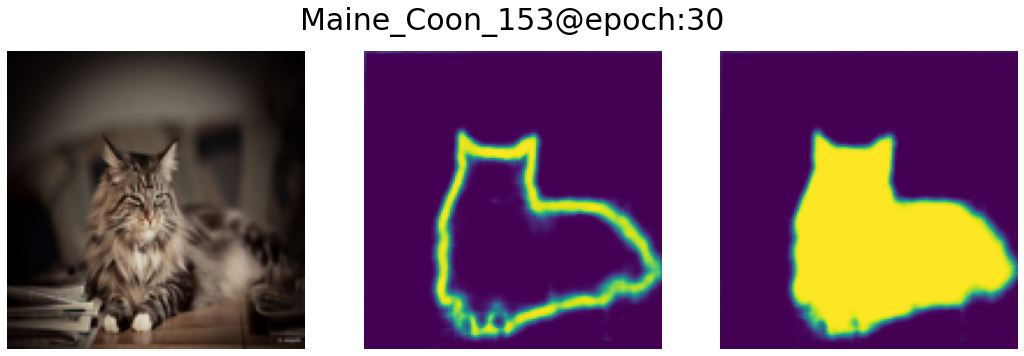

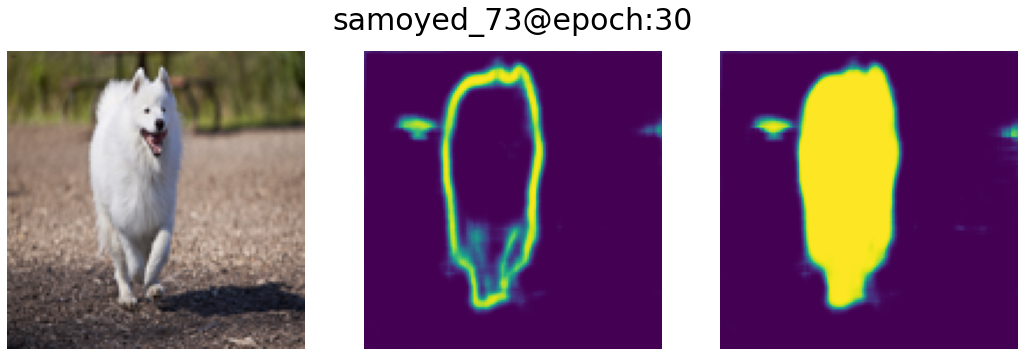

In [10]:
besnet = BESNet(3).to(device)
optimizer = torch.optim.Adam(besnet.parameters(), lr = lr)
criterion_bdp = F.binary_cross_entropy
criterion_mdp = mdp_bece_loss
list_sample_result = []

for epoch in range(num_epoch):
    besnet.train()
    pbar = tqdm.tqdm(total = len(dataloaders['train']), position = 0, desc = f'Epoch {epoch+1}/{num_epoch}')
    
    # show results for example files
    list_plots = []
    show_shiba = True
    for img_torch, img_raw, fname in zip(list_images, list_images_reshaped, sample_image_files):
        list_plots.append(show_result_besnet(besnet, img_torch, img_raw, f'{fname}@epoch:{epoch}', show_result = show_shiba))
        show_shiba = False
    list_sample_result.append(list_plots)
    
    for image, mask, edge in dataloaders['train']:
        # Load data
        image = image.to(device)
        mask = mask.to(device)
        edge = edge.to(device)
        # Forward
        bdp, mdp = besnet(image)
        # Get Loss
        bdp_loss = criterion_bdp(bdp, edge)
        mdp_loss = criterion_mdp(mdp, mask, bdp)
        loss = bdp_loss + mdp_loss
        # weight updates
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'bdp_error': np.round(bdp_loss.item(), 2), 'mdp_error': np.round(mdp_loss.item(), 2), 'total_error': np.round(loss.item(), 2)})
        pbar.update(1)
    clear_output(wait = True)
    
# show results for example files
list_plots = []
for img_torch, img_raw, fname in zip(list_images, list_images_reshaped, sample_image_files):
    list_plots.append(show_result_besnet(besnet, img_torch, img_raw, f'{fname}@epoch:{epoch+1}', show_result = True))
list_sample_result.append(list_plots)

for idx, fname in enumerate(sample_image_files):
    list_sample_result[0][idx].save(fp = f'./images/pet@besnet_with_bece-{fname}.gif', format = 'GIF', append_images = [list_sample_result[i+1][idx] for i in range(num_epoch)], save_all = True, duration = 200, loop = 0)

Progression result (gif file)

<img src="./images/pet@besnet_with_bece-shiba_inu_100.gif" width="750" align="center">